In [9]:
def align(seq1, seq2, match=1, gap_penalty=1, mismatch_penalty=1):
    m, n = len(seq1), len(seq2)
    # Initialize DP matrix and traceback pointers
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    traceback = [[None] * (n + 1) for _ in range(m + 1)]
    
    max_score = 0
    max_pos = None

    # Fill the DP matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                match_score = dp[i - 1][j - 1] + match
            else:
                match_score = dp[i - 1][j - 1] - mismatch_penalty

            gap_seq1 = dp[i - 1][j] - gap_penalty
            gap_seq2 = dp[i][j - 1] - gap_penalty

            dp[i][j] = max(0, match_score, gap_seq1, gap_seq2)

            # Store traceback direction
            if dp[i][j] == match_score:
                traceback[i][j] = "DIAG"
            elif dp[i][j] == gap_seq1:
                traceback[i][j] = "UP"
            elif dp[i][j] == gap_seq2:
                traceback[i][j] = "LEFT"

            # Update max score position
            if dp[i][j] > max_score:
                max_score = dp[i][j]
                max_pos = (i, j)

    # Traceback to find the optimal alignment
    aligned_seq1 = []
    aligned_seq2 = []
    i, j = max_pos

    while dp[i][j] != 0:
        if traceback[i][j] == "DIAG":
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
        elif traceback[i][j] == "UP":
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append("-")
            i -= 1
        elif traceback[i][j] == "LEFT":
            aligned_seq1.append("-")
            aligned_seq2.append(seq2[j - 1])
            j -= 1

    # Reverse the sequences (since we traceback from the end)
    aligned_seq1 = ''.join(reversed(aligned_seq1))
    aligned_seq2 = ''.join(reversed(aligned_seq2))

    return aligned_seq1, aligned_seq2, max_score


In [10]:
seq1, seq2, score = align('tgcatcgagaccctacgtgac', 'actagacctagcatcgac')
print(seq1, seq2, score)

agacccta-cgt-gac aga-cctagcatcgac 8


In [11]:
seq1, seq2, score = align('tgcatcgagaccctacgtgac', 'actagacctagcatcgac', gap_penalty=2)
print(seq1, seq2, score)


gcatcga gcatcga 7


Exercise 2


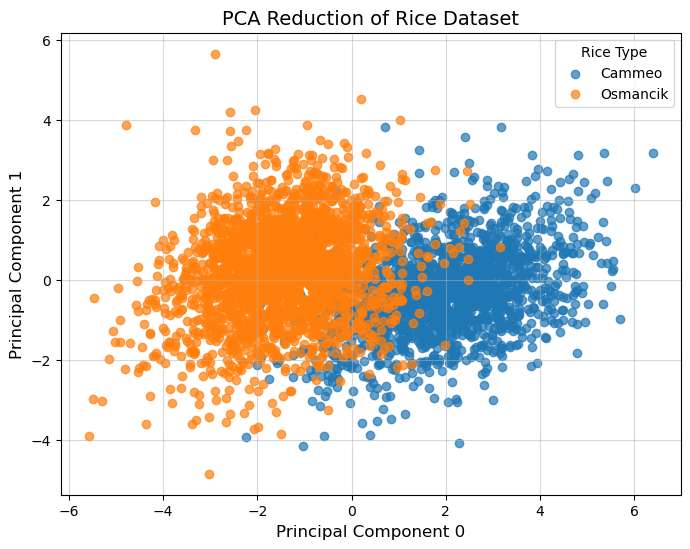

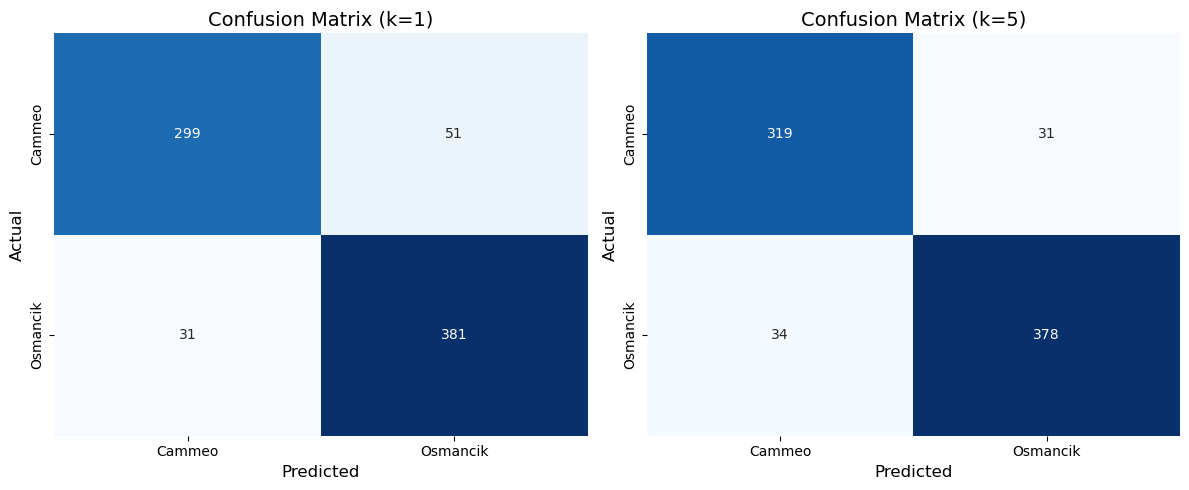

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/yihang/Desktop/BIS_634/HW5/Rice_Dataset_Commeo_and_Osmancik/Rice_Cammeo_Osmancik.xlsx'
data = pd.read_excel(file_path)

# Normalize the features
features = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 
            'Eccentricity', 'Convex_Area', 'Extent']
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data[features])

# Apply PCA to reduce dimensions to 2 PCs
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_normalized)
data['PC0'], data['PC1'] = data_reduced[:, 0], data_reduced[:, 1]
#I added two extra columns to the original data


# QuadTree Implementation
class QuadTree:
    def __init__(self, points, x_bounds, y_bounds, max_points=4):
        self.points = points
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.children = []
        self.max_points = max_points
        self._split()

    def _split(self):
        if len(self.points) <= self.max_points:
            return
        mid_x = (self.x_bounds[0] + self.x_bounds[1]) / 2
        mid_y = (self.y_bounds[0] + self.y_bounds[1]) / 2
        quadrants = [
            ([], (self.x_bounds[0], mid_x), (self.y_bounds[0], mid_y)),
            ([], (mid_x, self.x_bounds[1]), (self.y_bounds[0], mid_y)),
            ([], (self.x_bounds[0], mid_x), (mid_y, self.y_bounds[1])),
            ([], (mid_x, self.x_bounds[1]), (mid_y, self.y_bounds[1])),
        ]
        for point in self.points:
            x, y, _ = point
            for quadrant in quadrants:
                if quadrant[1][0] <= x <= quadrant[1][1] and quadrant[2][0] <= y <= quadrant[2][1]: ##check 'contains'
                    quadrant[0].append(point)
                    break
        self.points = []
        for q_points, q_x_bounds, q_y_bounds in quadrants:
            if q_points:
                self.children.append(QuadTree(q_points, q_x_bounds, q_y_bounds, self.max_points))

    def _within_distance(self, x, y, d):
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds
        closest_x = min(max(x, x_min), x_max)
        closest_y = min(max(y, y_min), y_max)
        return (closest_x - x) ** 2 + (closest_y - y) ** 2 <= d ** 2

    def query(self, x, y, k):
        candidates = []
        def search(node):
            if not node.children:
                candidates.extend(node.points)
            else:
                for child in node.children:
                    if child._within_distance(x, y, float('inf')):
                        search(child)
        search(self)
        candidates.sort(key=lambda p: (p[0] - x) ** 2 + (p[1] - y) ** 2)
        return candidates[:k]

# Prepare data for QuadTree-based KNN
train_data, test_data = train_test_split(data[['PC0', 'PC1', 'Class']].to_numpy(), test_size=0.2, random_state=42)
x_min, x_max = train_data[:, 0].min(), train_data[:, 0].max()
y_min, y_max = train_data[:, 1].min(), train_data[:, 1].max()

# Build the QuadTree
quadtree = QuadTree(train_data, (x_min, x_max), (y_min, y_max))

# KNN prediction function
def knn_predict(quadtree, test_points, k):
    predictions = []
    for x, y, _ in test_points:
        neighbors = quadtree.query(x, y, k)
        classes = [neighbor[2] for neighbor in neighbors]
        predictions.append(Counter(classes).most_common(1)[0][0])
    return predictions

# Test KNN with k=1 and k=5
test_labels = test_data[:, 2]
predictions_k1 = knn_predict(quadtree, test_data, k=1)
predictions_k5 = knn_predict(quadtree, test_data, k=5)

# Confusion Matrices, this and the visualization below are assisted by CHATGPT
confusion_k1 = pd.crosstab(pd.Series(test_labels, name='Actual'), pd.Series(predictions_k1, name='Predicted'))
confusion_k5 = pd.crosstab(pd.Series(test_labels, name='Actual'), pd.Series(predictions_k5, name='Predicted'))


plt.figure(figsize=(8, 6))
for rice_type, group in data.groupby('Class'):
    plt.scatter(group['PC0'], group['PC1'], label=rice_type, alpha=0.7)

plt.title('PCA Reduction of Rice Dataset', fontsize=14)
plt.xlabel('Principal Component 0', fontsize=12)
plt.ylabel('Principal Component 1', fontsize=12)
plt.legend(title='Rice Type')
plt.grid(True, alpha=0.5)
plt.show()
# Heatmaps for confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_k1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (k=1)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.subplot(1, 2, 2)
sns.heatmap(confusion_k5, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (k=5)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()
